In [79]:
import numpy as np
import pandas as pd
import xarray as xr
import codebase

In [39]:
res_shp = codebase.load_data.load_GRanD()

In [40]:
# Create subset from dam name or from lat/lon values
dam_name = 'Indirasagar'
bbox_array = [76.420001, 21.9051, 76.90001, 22.47001]


subset_gpd = codebase.area_subsets.check_for_multiple_dams(dam_name,res_shp)
subset_bbox = subset_gpd.geometry.buffer(0).bounds

# subset_bbox = pd.DataFrame(
#         data=np.array(bbox_array).reshape(1, -1),
#         columns=["minx", "miny", "maxx", "maxy"],
#     )

In [87]:
dem_DA = codebase.load_data.load_DEM_subset_as_rxrDA(subset_bbox)
fw_DA = codebase.load_data.load_CYGNSS_001_all_months(subset_bbox)

In [115]:
np.testing.assert_allclose(dem_DA['lat'].values, fw_DA['lat'].values)
dem_DA['lat'] = fw_DA['lat']
np.testing.assert_allclose(dem_DA['lon'].values, fw_DA['lon'].values)
dem_DA['lon'] = fw_DA['lon']

In [116]:
fw_DA_binary = codebase.area_calcs.cygnss_convert_to_binary(fw_DA)
fw_DA_binary['time'] = codebase.time_series_calcs.CYGNSS_timestep_to_pdTimestamp(fw_DA['time'])

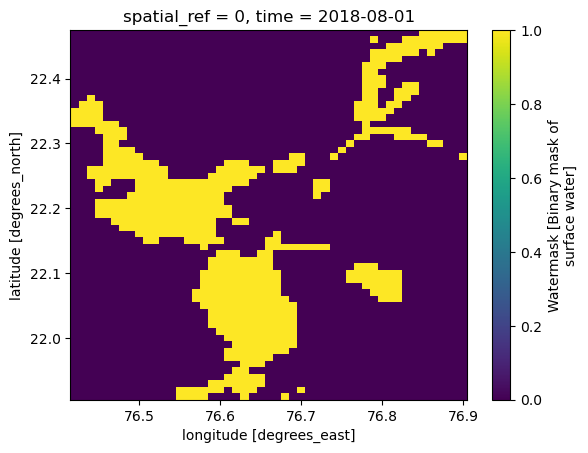

In [58]:
fw_DA_binary[0,:,:].plot()

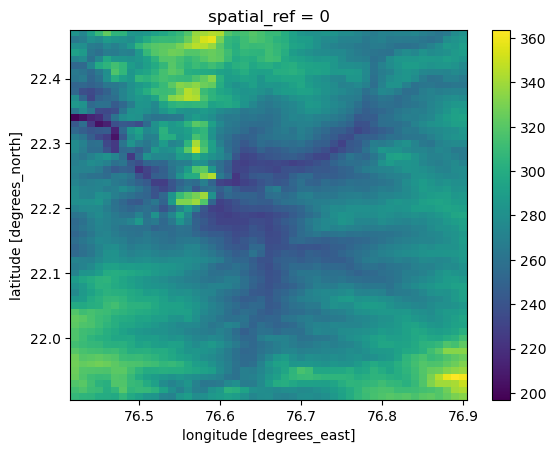

In [43]:
dem_DA.plot()

In [118]:
dem_subset = dem_DA.where(fw_DA_binary==1)

In [123]:
dem_subset['time']

<xarray.DataArray 'time' (time: 57)>
array(['2018-08-01T00:00:00.000000000', '2018-09-01T00:00:00.000000000',
       '2018-10-01T00:00:00.000000000', '2018-11-01T00:00:00.000000000',
       '2018-12-01T00:00:00.000000000', '2019-01-01T00:00:00.000000000',
       '2019-02-01T00:00:00.000000000', '2019-03-01T00:00:00.000000000',
       '2019-04-01T00:00:00.000000000', '2019-05-01T00:00:00.000000000',
       '2019-06-01T00:00:00.000000000', '2019-07-01T00:00:00.000000000',
       '2019-08-01T00:00:00.000000000', '2019-09-01T00:00:00.000000000',
       '2019-10-01T00:00:00.000000000', '2019-11-01T00:00:00.000000000',
       '2019-12-01T00:00:00.000000000', '2020-01-01T00:00:00.000000000',
       '2020-02-01T00:00:00.000000000', '2020-03-01T00:00:00.000000000',
       '2020-04-01T00:00:00.000000000', '2020-05-01T00:00:00.000000000',
       '2020-06-01T00:00:00.000000000', '2020-07-01T00:00:00.000000000',
       '2020-08-01T00:00:00.000000000', '2020-09-01T00:00:00.000000000',
       '2020-10-01T00:00:00.000000000', '2020-11-01T00:00:00.000000000',
       '2020-12-01T00:00:00.000000000', '2021-01-01T00:00:00.000000000',
       '2021-02-01T00:00:00.000000000', '2021-03-01T00:00:00.000000000',
       '2021-04-01T00:00:00.000000000', '2021-05-01T00:00:00.000000000',
       '2021-06-01T00:00:00.000000000', '2021-07-01T00:00:00.000000000',
       '2021-08-01T00:00:00.000000000', '2021-09-01T00:00:00.000000000',
       '2021-10-01T00:00:00.000000000', '2021-11-01T00:00:00.000000000',
       '2021-12-01T00:00:00.000000000', '2022-01-01T00:00:00.000000000',
       '2022-02-01T00:00:00.000000000', '2022-03-01T00:00:00.000000000',
       '2022-04-01T00:00:00.000000000', '2022-05-01T00:00:00.000000000',
       '2022-06-01T00:00:00.000000000', '2022-07-01T00:00:00.000000000',
       '2022-08-01T00:00:00.000000000', '2022-09-01T00:00:00.000000000',
       '2022-10-01T00:00:00.000000000', '2022-11-01T00:00:00.000000000',
       '2022-12-01T00:00:00.000000000', '2023-01-01T00:00:00.000000000',
       '2023-02-01T00:00:00.000000000', '2023-03-01T00:00:00.000000000',
       '2023-04-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2018-08-01 2018-09-01 ... 2023-04-01

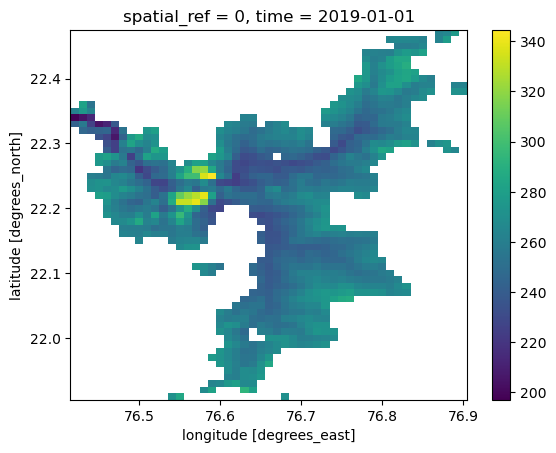

In [122]:
dem_subset[:,:,5].plot()